# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
tag = 'coding'
homeo_methods = ['None', 'HAP', 'HEH']


record_num_batches = 2**12

seed = 42
np.random.seed(seed)

from shl_scripts.shl_experiments import SHL
shl = SHL()
data = shl.get_data(matname=tag)
indx = np.random.permutation(data.shape[0])[:record_num_batches]

list_figures = []

dico = {}
for homeo_method in homeo_methods:
    print(19*'🐶' + homeo_method + 10*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## theory



Sum of non-zero coefficients 118903 ~= 118784
average non-zeros 224.76937618147448 ~= 224.5444234404537


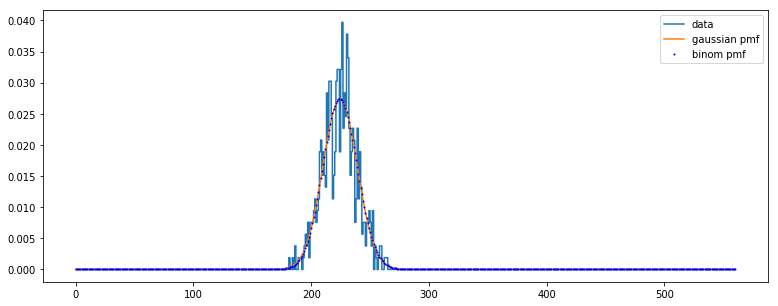

In [4]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

# define the theoretical standard deviation
sd = np.sqrt(rho*(1-rho)*record_num_batches)

# the binomial probability is defined from 0 to record_num_batches \times shl.n_dictionary
# for visualization, we show the part around non-zero probabilities:
#record_num_batches_high = int(rho * record_num_batches + 15. * sd)
record_num_batches_high = int(2.5 * rho * record_num_batches)
bins = np.arange(record_num_batches_high)

print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
fig, ax= plt.subplots(figsize=(13, 5))
smarts, edges = np.histogram(np.count_nonzero(sparse_code_binary, axis=0), density=True, bins=bins)
smarts /= smarts.sum()
ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data');
#edges_mid = .5*( edges[1:] + edges[:-1] )
#print(rho, s, edges)
proba = np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
proba /= proba.sum()
ax.plot(edges, proba, label='gaussian pmf');
proba_binom = binom.pmf(edges, record_num_batches, rho)
proba_binom /= proba_binom.sum()
ax.plot(edges, proba_binom, 'bo', ms=1, label='binom pmf')
ax.legend()

In [5]:
from shl_scripts.shl_tools import get_logL

In [6]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    logL = get_logL(sparse_code_binary)
    print ('log-likelihood for random sample=', logL.mean(), '+/-', logL.std())


log-likelihood for random sample= -4.134702550042896 +/- 0.7862441545906274
log-likelihood for random sample= -4.125217923350292 +/- 0.7443395695458311
log-likelihood for random sample= -4.073030952557048 +/- 0.7270493688977726
log-likelihood for random sample= -4.1540285615443535 +/- 0.7470255366111315
log-likelihood for random sample= -4.0810580992824255 +/- 0.7132391625589365
log-likelihood for random sample= -4.070474905079876 +/- 0.6161115379004786
log-likelihood for random sample= -4.099604537595131 +/- 0.6675656149563598
log-likelihood for random sample= -4.053612090640261 +/- 0.6599053200920554
log-likelihood for random sample= -4.100209014303653 +/- 0.706551125451472
log-likelihood for random sample= -4.144630625986534 +/- 0.7620266709449962


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.03079522635124536
average std of codewords =  0.1613287201915681
l0-sparseness of codewords =  0.052842830665170135
std of the average of individual patches =  0.005929161594270047


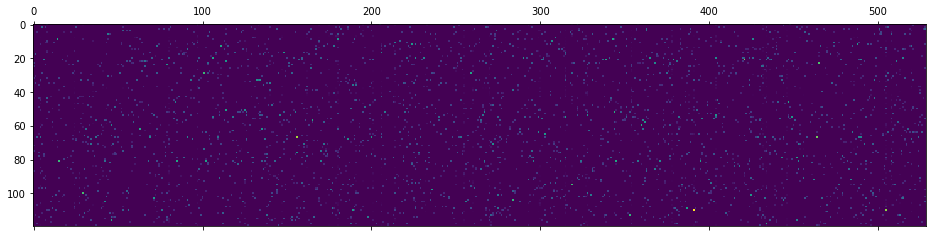

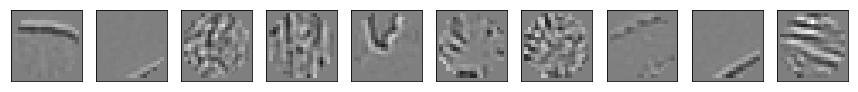

number of codes, size of reconstructed images =  (4096, 441)


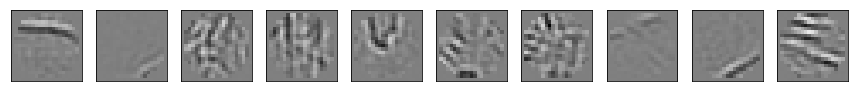

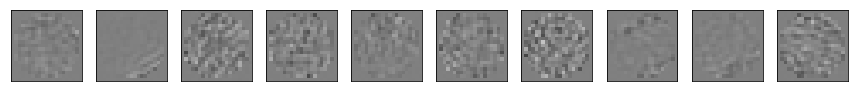

average of data patches =  -7.89752670459092e-05 +/- 0.004867137808471049
average of residual patches =  -0.0002937247150602481 +/- 0.00391090656259611
median energy of data =  0.19067788328947594
average energy of data =  0.1909938645300175 +/- 0.06987009086401882
average error =  -0.0002937247150602481 +/- 0.09590294707072887
average energy of residual =  0.09059986676550356 +/- 0.031450368410119806
median energy of residual =  0.0881263496699402
average gain of coding =  2.1104588653766783 +/- 0.3362396088642465
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.031709041925514
average std of codewords =  0.1622674492403725
l0-sparseness of codewords =  0.05423244771975425
std of the average of individual patches =  0.003632007140860762


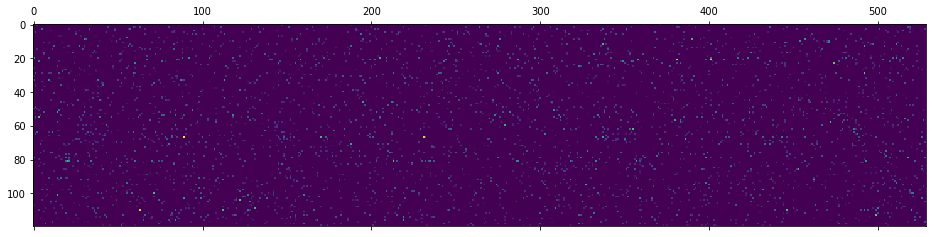

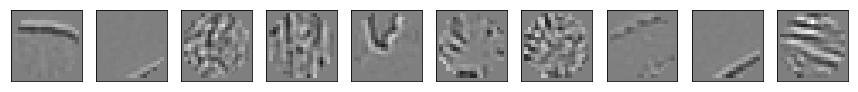

number of codes, size of reconstructed images =  (4096, 441)


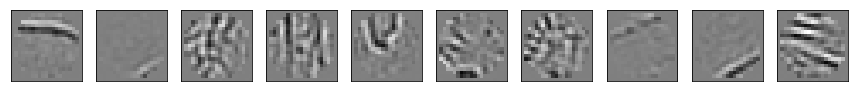

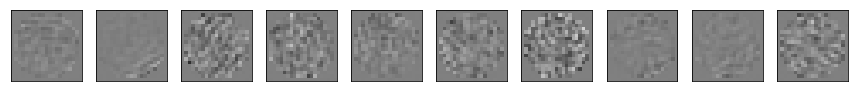

average of data patches =  -7.89752670459092e-05 +/- 0.004867137808471049
average of residual patches =  1.2088453989784732e-05 +/- 0.0038608302865000017
median energy of data =  0.19067788328947594
average energy of data =  0.1909938645300175 +/- 0.06987009086401882
average error =  1.2088453989784732e-05 +/- 0.09349363072809014
average energy of residual =  0.08711583887974272 +/- 0.033939501309387346
median energy of residual =  0.08595531068202307
average gain of coding =  2.2407649433070604 +/- 0.36860610211966177
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.031858849464410643
average std of codewords =  0.1623981221259027
l0-sparseness of codewords =  0.0545656604442344
std of the average of individual patches =  0.002946713723961977


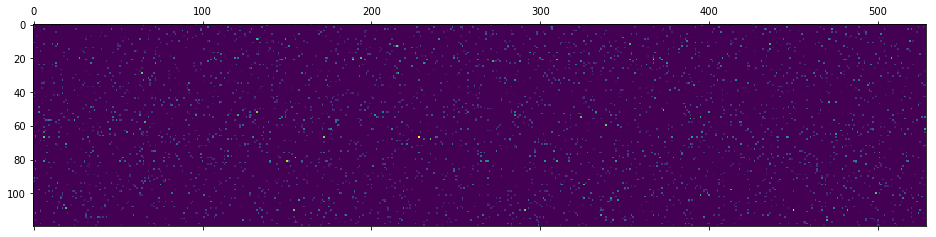

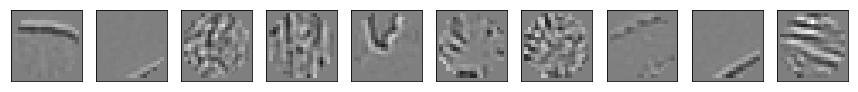

number of codes, size of reconstructed images =  (4096, 441)


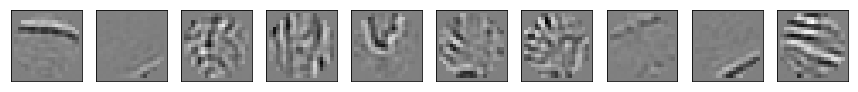

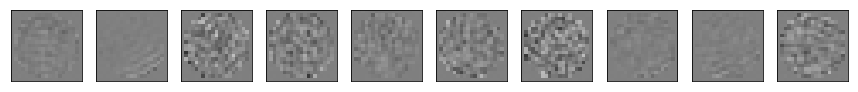

average of data patches =  -7.89752670459092e-05 +/- 0.004867137808471049
average of residual patches =  2.1495828727615744e-05 +/- 0.003955842667066423
median energy of data =  0.19067788328947594
average energy of data =  0.1909938645300175 +/- 0.06987009086401882
average error =  2.1495828727615744e-05 +/- 0.09309366688018339
average energy of residual =  0.08639141702669095 +/- 0.034683632153936515
median energy of residual =  0.08636211135679273
average gain of coding =  2.2847042436384912 +/- 0.41489003378932987


In [7]:
from shl_scripts.shl_tools import print_stats

from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    print(42*'🐶')
    print(19*'🐶' + homeo_method + 10*'🐶')
    print(42*'🐶')
    
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, 
                                 P_cum=dico[homeo_method].P_cum, l0_sparseness=shl.l0_sparseness, C=shl.C)
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

In [8]:
sparse_code[homeo_method].shape

(4096, 529)

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Average of non-zero coefficients 0.052842830665170135 ~= 0.054820415879017016
Mean of non-zero coefficients 216.44423440453687 ~= 224.5444234404537
Mean of non-zero coefficients 216.44423440453687 +/- 134.45591968453263
Median of non-zero coefficients 180.0
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Average of non-zero coefficients 0.05423244771975425 ~= 0.054820415879017016
Mean of non-zero coefficients 222.13610586011342 ~= 224.5444234404537
Mean of non-zero coefficients 222.13610586011342 +/- 53.51307103859049
Median of non-zero coefficients 212.0


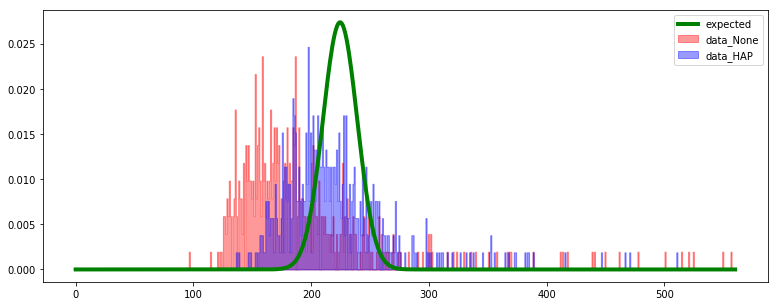

In [9]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method, color in zip(homeo_methods, ['r', 'b']):
    print(42*'🐶')
    print(19*'🐶' + homeo_method + 10*'🐶')
    print(42*'🐶')
    print('Average of non-zero coefficients', (sparse_code[homeo_method]>0).mean(), '~=', rho)
    n_i = np.count_nonzero(sparse_code[homeo_method], axis=0)
    print('Mean of non-zero coefficients', n_i.mean(), '~=', rho*record_num_batches)
    print('Mean of non-zero coefficients', n_i.mean(), '+/-', n_i.std())
    print('Median of non-zero coefficients', np.median(n_i))
    smarts, edges = np.histogram(n_i, density=True, bins=bins)
    smarts /= smarts.sum()
    # ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data_' + homeo_method);
    ax.fill_between(edges[:-1], smarts, step='pre', label='data_' + homeo_method, alpha=.4, color=color);

proba = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
#proba /= proba.sum()
ax.plot(edges, proba, label='expected', c='g', lw=4)
ax.legend();

In [10]:
rho, sparse_code[homeo_method].mean(), homeo_methods

(0.054820415879017016, 0.031709041925514, ['None', 'HAP', 'HEH'])

## measuring the distance to independance 

In [11]:
#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    logL = get_logL(sparse_code[homeo_method])
    print ('log-likelihood for homeo_method=', homeo_method, 'is', logL.mean(), '+/-', logL.std())
    #ax.vline(edges, proba, label=homeo_method)

logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
print ('log-likelihood for theory is', logL.mean(), '+/-', logL.std())
#for _ in range(10):
#    logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
#ax.plot(edges, proba, label='theory')
#ax.legend();

log-likelihood for homeo_method= None is -47.67266174769135 +/- 186.016274992172
log-likelihood for homeo_method= HAP is -10.408023480851286 +/- 27.102008786994496
log-likelihood for homeo_method= HEH is -4.699719314416119 +/- 1.633857654929319
log-likelihood for theory is -4.129709393150773 +/- 0.6725379361699599


## Version used

In [12]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
pandas 0.22.0
Sat Mar 17 15:45:54 2018 CET